# TFHub BERT API 익숙해지기

In [ ]:
!pip install -q -U tensorflow-text
!pip install -q -U tf-models-official

In [3]:
import os, shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)


tf.get_logger().setLevel('ERROR')

os.environ["TFHUB_CACHE_DIR"] = "/data/tfhub"
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## single segments 간단사용

In [4]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
)
encoder_inputs = preprocessor(text_input)

In [5]:
encoder_inputs   # seq_length=128

{'input_mask': <tf.Tensor 'keras_layer/StatefulPartitionedCall:0' shape=(None, 128) dtype=int32>,
 'input_word_ids': <tf.Tensor 'keras_layer/StatefulPartitionedCall:2' shape=(None, 128) dtype=int32>,
 'input_type_ids': <tf.Tensor 'keras_layer/StatefulPartitionedCall:1' shape=(None, 128) dtype=int32>}

## General usage

* https://www.tensorflow.org/text/tutorials/bert_glue
* 복수 개의 segment 지정 가능
* seq_length 조절 가능 

In [6]:
def make_bert_preprocess_model(input_layer_names, seq_length=128):
    input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=input_layer_name) for input_layer_name in input_layer_names]
    
    preprocessor = hub.load(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
    )

    # step #1 : tokenize batches of text inputs
    tokenizer = hub.KerasLayer(preprocessor.tokenize, name='tokenizer')
    segments = [tokenizer(segment) for segment in input_segments]

    # setp #2 : pack input sequences for the transformer encoder
    packer = hub.KerasLayer(
        preprocessor.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name='packer')
    
    model_inputs = packer(segments)
    
    return tf.keras.Model(input_segments, model_inputs)

In [7]:
test_preprocess_model = make_bert_preprocess_model(['input_1', 'input_2'], 12)
test_text = [np.array(['First sentence']), np.array(['second sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :12])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :12])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :12])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 12)
Word Ids       :  tf.Tensor([ 101 2034 6251  102 2117 6251  102    0    0    0    0    0], shape=(12,), dtype=int32)
Shape Mask     :  (1, 12)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 0 0 0 0 0], shape=(12,), dtype=int32)
Shape Type Ids :  (1, 12)
Type Ids       :  tf.Tensor([0 0 0 0 1 1 1 0 0 0 0 0], shape=(12,), dtype=int32)


## 동작 예제

* https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [8]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

### 전처리 모델

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### BERT 모델 사용

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928098  -0.18611875  0.36673862  0.15233669  0.6550441
  0.9681153  -0.9486271   0.00216187 -0.9877731   0.06842709 -0.9763059 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894632   0.34321228  0.33231512 ...  0.2130093   0.7102075
  -0.05771134]
 [-0.2874204   0.31981045 -0.2301855  ...  0.58455133 -0.2132975
   0.7269206 ]
 [-0.6615706   0.6887687  -0.8743295  ...  0.10877323 -0.26173234
   0.4785541 ]
 ...
 [-0.22561094 -0.28925622 -0.07064424 ...  0.4756608   0.8327711
   0.40025336]
 [-0.29824206 -0.27473098 -0.05450578 ...  0.488498    1.0955355
   0.18163346]
 [-0.44378227  0.00930709  0.07223769 ...  0.1729009   1.1833239
   0.07898016]]


### downstream task의 한 부분으로의 사용

In [13]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocess_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocess_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
    
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [14]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
                                   

tf.Tensor([[0.42834967]], shape=(1, 1), dtype=float32)


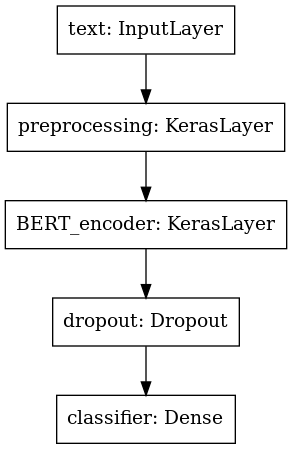

In [15]:
tf.keras.utils.plot_model(classifier_model)

### IMDB data에 대해서 훈련

In [16]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='/data/imdb/',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/data/imdb/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/data/imdb/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/data/imdb/aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [19]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i][:40]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof th'
Label : 0 (neg)
Review: b'David Mamet is a very interesting and a '
Label : 0 (neg)
Review: b'Great documentary about the lives of NY '
Label : 1 (pos)


In [20]:
# 훈련
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [21]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [22]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 37s 60ms/step - loss: 0.7344 - binary_accuracy: 0.4999 - val_loss: 0.7001 - val_binary_accuracy: 0.5024
Epoch 2/5
625/625 [==============================] - 37s 59ms/step - loss: 0.6985 - binary_accuracy: 0.5253 - val_loss: 0.6775 - val_binary_accuracy: 0.5134
Epoch 3/5
625/625 [==============================] - 37s 60ms/step - loss: 0.6808 - binary_accuracy: 0.5404 - val_loss: 0.6647 - val_binary_accuracy: 0.5286
Epoch 4/5
625/625 [==============================] - 37s 60ms/step - loss: 0.6731 - binary_accuracy: 0.5493 - val_loss: 0.6581 - val_binary_accuracy: 0.5338
Epoch 5/5
625/625 [==============================] - 37s 60ms/step - loss: 0.6680 - binary_accuracy: 0.5572 - val_loss: 0.6560 - val_binary_accuracy: 0.5360


In [23]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 37s 48ms/step - loss: 0.6572 - binary_accuracy: 0.5500
Loss: 0.6571881175041199
Accuracy: 0.5500400066375732


#### 추론을 위해 saved_model 로 내보내기

In [24]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [26]:
# 다시 로딩 후 사용 

reloaded_model = tf.saved_model.load(saved_model_path)

def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                             for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.511192
input: The movie was great!           : score: 0.548886
input: The movie was meh.             : score: 0.545740
input: The movie was okish.           : score: 0.473311
input: The movie was terrible...      : score: 0.551627



In [27]:
# 서빙 시그니처로 사용 

serving_results = reloaded_model.signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.511192
input: The movie was great!           : score: 0.548886
input: The movie was meh.             : score: 0.545740
input: The movie was okish.           : score: 0.473311
input: The movie was terrible...      : score: 0.551627

